In [1]:
# --- Installation and Environment Configuration ---
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate bitsandbytes datasets scipy matplotlib pandas tqdm wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import copy
import gc
import wandb
import time

# --- Hardware Verification ---
print(f"PyTorch: {torch.__version__}")
try:
    _ = torch.float8_e4m3fn
    print("✅ Hardware Ready: Native FP8 Supported.")
except AttributeError:
    raise RuntimeError("❌ Error: FP8 not supported. Use L4 or A100 GPU.")

device = "cuda"

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
PyTorch: 2.5.1+cu121
✅ Hardware Ready: Native FP8 Supported.


In [2]:
# --- Seeding for Reproducibility ---
import random
import numpy as np
from transformers import set_seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Configuration & Experiment Controls**

In [3]:
# --- Configuration & Hyperparameters ---
MODELS_TO_TEST = ["Qwen/Qwen2.5-1.5B-Instruct"]
SENSITIVITY_THRESHOLDS = [0.0, 0.05, 0.1, 0.2, 0.3]
EVAL_SAMPLES = 5000
WANDB_PROJECT_NAME = "KLD_Quantization_FP4_vs_FP8"

In [4]:
import wandb
import pandas as pd
from datasets import load_dataset, concatenate_datasets
import os
os.environ["WANDB_QUIET"] = "true"

wandb.login()

if 'results_table' not in globals():
    results_table = []

print("Loading MMLU Dataset...")
try:
    mmlu_dataset = concatenate_datasets([
        load_dataset("cais/mmlu", "all", split='test')
    ])
    print(f"MMLU Dataset Loaded. Size: {len(mmlu_dataset)} samples.")
except Exception as e:
    print(f"Error loading MMLU: {e}")
    from datasets import Dataset
    mmlu_dataset = Dataset.from_dict({
        "question": ["1+1=?"], "choices": [["1", "2", "3", "4"]], "answer": [1]
    })

print("Global setup complete. Ready for Step 2.")

wandb: Currently logged in as: yq171014 (yq171014-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading MMLU Dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MMLU Dataset Loaded. Size: 14042 samples.
Global setup complete. Ready for Step 2.


## **Metrics & Helper Functions**

In [5]:
def recursive_getattr(obj, attr):
    for part in attr.split('.'):
        obj = getattr(obj, part)
    return obj

def recursive_setattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    parent = recursive_getattr(obj, pre) if pre else obj
    setattr(parent, post, val)

In [6]:
# --- Metrics and Evaluation Utilities ---

def compute_kld(logits_p, logits_q):
    """
    Computes the Kullback-Leibler Divergence (KLD) between two sets of logits.
    """
    p_probs = F.softmax(logits_p, dim=-1)
    q_log_probs = F.log_softmax(logits_q, dim=-1)
    return nn.KLDivLoss(reduction='batchmean')(q_log_probs, p_probs).item()

def calculate_flip_rate(base_preds, new_preds):
    """
    Calculates the percentage of predictions that differ from the baseline predictions.
    """
    if not base_preds or not new_preds: return 0.0
    flips = sum([1 for b, n in zip(base_preds, new_preds) if b != n])
    return flips / len(base_preds)

def compute_perplexity(model, tokenizer):
    """
    Computes the perplexity of the model on a subset of the WikiText-2 dataset.
    """
    encodings = tokenizer("\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:20]), return_tensors="pt")
    max_length = model.config.max_position_embeddings
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Computing PPL"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            nlls.append(outputs.loss)

        prev_end_loc = end_loc
        if end_loc == seq_len: break

    return torch.exp(torch.stack(nlls).mean()).item()

def measure_efficiency(model, tokenizer, input_text="Hello world"):
    """
    Measures inference latency, static memory usage (weights), and peak memory usage.
    """
    # 1. Cleanup resources
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    # 2. Measure Static Memory (Model Weights Only)
    # This reflects the storage impact of quantization
    static_mem_bytes = torch.cuda.memory_allocated()
    static_mem_gb = static_mem_bytes / 1024**3

    # 3. Run Inference
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    start_time = time.time()
    with torch.no_grad():
        _ = model.generate(**input_ids, max_new_tokens=50, min_new_tokens=50)
    torch.cuda.synchronize()
    end_time = time.time()

    # 4. Measure Peak Memory (Weights + KV Cache + Temp Buffers)
    # This reflects the total operational cost
    peak_mem_bytes = torch.cuda.max_memory_allocated()
    peak_mem_gb = peak_mem_bytes / 1024**3

    latency = end_time - start_time

    return latency, static_mem_gb, peak_mem_gb

def evaluate_full_suite(model, tokenizer, dataset, metric_name):
    """
    Runs the full evaluation suite: Accuracy, Perplexity, and Efficiency metrics.
    """
    print(f"--- Evaluating: {metric_name} ---")

    # 1. Evaluate Accuracy on MMLU
    preds, truths = get_mmlu_predictions(model, dataset, EVAL_SAMPLES)
    acc = sum([1 for p, g in zip(preds, truths) if p == g]) / len(truths)

    # 2. Evaluate Perplexity
    ppl = compute_perplexity(model, tokenizer)

    # 3. Evaluate Efficiency (Latency & Memory)
    lat, static_mem, peak_mem = measure_efficiency(model, tokenizer)

    print(f"Results -> Acc: {acc:.2%}, PPL: {ppl:.2f}, Latency: {lat:.2f}s, Static Mem: {static_mem:.2f}GB, Peak Mem: {peak_mem:.2f}GB")

    # Return gathered metrics
    return acc, ppl, lat, static_mem, peak_mem, preds

In [7]:
# --- MMLU Evaluation Logic ---
def format_mmlu_prompt(example):
    options = [f"{label}. {example['choices'][i]}" for i, label in enumerate(['A', 'B', 'C', 'D'])]
    prompt_text = f"Question: {example['question']}\nOptions:\n" + "\n".join(options) + "\nAnswer:"
    messages = [
        {"role": "system", "content": "Output only the single letter (A, B, C, or D) corresponding to the correct answer."},
        {"role": "user", "content": prompt_text}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def get_mmlu_predictions(model, dataset, num_samples):
    predictions, ground_truths = [], []
    choices = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(c)[0] for c in choices]

    for i in tqdm(range(min(num_samples, len(dataset))), desc="MMLU Eval"):
        ex = dataset[i]
        inputs = tokenizer(format_mmlu_prompt(ex), return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1, choice_ids]
            pred = choices[torch.argmax(logits).item()]
        predictions.append(pred)
        ground_truths.append(choices[ex['answer']])
    return predictions, ground_truths

## **Advanced Sensitivity Profiling**

In [8]:
def get_base_logits(model_ref, calib_input):
    # --- Baseline Logits Calculation ---
    print("Get base logits for the base model")
    model_ref.eval()

    with torch.no_grad():
        ref_device = next(model_ref.parameters()).device
        base_logits = model_ref(calib_input.to(ref_device)).logits.to(device)

    return base_logits

In [9]:
import bitsandbytes as bnb
from functools import reduce

def profile_restoration_sensitivity(model_q, model_ref, calib_input, base_logits, granularity='layer'):
    """
    Profiles the sensitivity of each component by measuring the improvement in KLD
    when restoring that specific component from the quantized model (model_q)
    back to its FP16 counterpart (model_ref).

    Args:
        model_q: The quantized model.
        model_ref: The reference FP16 model.
        calib_input: Input data for calibration.
        base_logits: Logits from the baseline model.
        granularity: 'layer' (individual linear layers) or 'block' (entire attention/mlp blocks).

    Returns:
        sensitivity_scores: Dictionary mapping component name to KLD improvement (Higher means more sensitive).
    """
    print(f"Profiling Restoration Sensitivity (Granularity: {granularity})...")

    with torch.no_grad():
        current_logits = model_q(calib_input.to(device)).logits
        initial_kld = compute_kld(base_logits, current_logits)

    print(f"Initial Quantized KLD: {initial_kld:.6f}")

    sensitivity_scores = {}

    def get_module_by_name(module, access_string):
        names = access_string.split(sep='.')
        return reduce(getattr, names, module)

    # Determine items to iterate over based on granularity
    if granularity == 'block':
        if hasattr(model_q, 'model') and hasattr(model_q.model, 'layers'):
            # Create a list of (name, module) for Attention and MLP blocks within each transformer layer
            iterable_items = []
            for i, layer in enumerate(model_q.model.layers):
                # 1. Add Self-Attention Block
                if hasattr(layer, 'self_attn'):
                    iterable_items.append((f"{i}.self_attn", layer.self_attn))

                # 2. Add MLP Block
                if hasattr(layer, 'mlp'):
                    iterable_items.append((f"{i}.mlp", layer.mlp))

            # Prefix for accessing layers
            prefix = "model.model.layers"
        else:
            raise ValueError("Could not detect transformer blocks structure.")

        iterator = tqdm(iterable_items, desc="Profiling Parent Blocks (Attn & MLP)")
    elif granularity == 'layer':
        # Iterate over individual Linear layers (including 4-bit Linear layers)
        # filtering for those within MLP or Self-Attention blocks
        iterable_items = []
        for n, m in model_q.named_modules():
            if isinstance(m, (nn.Linear, bnb.nn.Linear4bit)) and ("mlp" in n or "self_attn" in n):
                iterable_items.append((n, m))
        iterator = tqdm(iterable_items, desc="Profiling Layers")

    # Restoration Loop: Temporarily restore each module to FP16 and measure KLD impact
    for name_or_idx, module_q in iterator:
        target_name = f"{prefix}.{name_or_idx}" if granularity == 'block' else name_or_idx
        try:
            module_ref = recursive_getattr(model_ref, target_name)
            backup_quant_module = recursive_getattr(model_q, target_name)
            module_fp16_gpu = copy.deepcopy(module_ref).to(device)
            recursive_setattr(model_q, target_name, module_fp16_gpu)

            # Measure New KLD with restored module
            with torch.no_grad():
                new_logits = model_q(calib_input.to(device)).logits
                new_kld = compute_kld(base_logits, new_logits)

            improvement = initial_kld - new_kld
            sensitivity_scores[target_name] = improvement

            # Revert to quantized module
            recursive_setattr(model_q, target_name, backup_quant_module)

            # Cleanup VRAM
            del module_fp16_gpu

        except Exception as e:
            print(f"Skipping {target_name}: {e}")

    return sensitivity_scores

## **The "Surgery" Implementation**

In [10]:
def perform_surgery(model, sensitive_names, fp16_model_cpu):
    """
    Restores specific sensitive layers in the quantized 'model' (on GPU)
    by replacing them with their original FP16 versions from 'fp16_model_cpu' (on CPU).

    This function uses deepcopy to handle various module types (Linear, Blocks, etc.).
    """
    count = 0
    print(f"Surgery: Replacing {len(sensitive_names)} Sensitive Layers with FP16...")

    for name in sensitive_names:
        try:
            # 1. Retrieve the original FP16 module from the CPU backup
            original_module = recursive_getattr(fp16_model_cpu, name)

            # 2. Create a deep copy and move it to the GPU
            #    Deepcopy ensures class type and configuration are preserved.
            module_fp16_gpu = copy.deepcopy(original_module).to(model.device)

            # 3. Replace the quantized module with the FP16 module
            recursive_setattr(model, name, module_fp16_gpu)

            count += 1

        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    print(f"Surgery Complete: {count} layers restored.")

# Model Selection & Baseline Evaluation

In [11]:
# --- Baseline Model Loading and Evaluation ---
CURRENT_MODEL_ID = MODELS_TO_TEST[0]

print(f"{'='*40}\nSelected Model: {CURRENT_MODEL_ID}\n{'='*40}")

tokenizer = AutoTokenizer.from_pretrained(CURRENT_MODEL_ID)
print("Loading FP16 Baseline (This may take a minute)...")
model_fp16 = AutoModelForCausalLM.from_pretrained(
    CURRENT_MODEL_ID,
    dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Evaluate Baseline Performance
base_acc, base_ppl, base_lat, base_static_mem, base_peak_mem, base_preds = evaluate_full_suite(
    model_fp16, tokenizer, mmlu_dataset, "FP16 Baseline"
)

# Log Baseline Metrics to WandB
run = wandb.init(project=WANDB_PROJECT_NAME, name=f"{CURRENT_MODEL_ID.split('/')[-1]}-Baseline", reinit=True)
wandb.log({
    "Accuracy": base_acc,
    "Perplexity": base_ppl,
    "Latency": base_lat,
    "Static_Memory": base_static_mem,
    "Peak_Memory": base_peak_mem,
    "Threshold": 0,
    "Flip_Rate": 0.0,
    "Method": "Baseline"
})
run.finish()

# Store Baseline Results
results_table.append({
    "Model": CURRENT_MODEL_ID,
    "Method": "FP16 Baseline",
    "Threshold": 0,
    "Acc": base_acc,
    "Flip": 0.0,
    "PPL": base_ppl,
    "Latency": base_lat,
    "Static Mem": base_static_mem,
    "Peak Mem": base_peak_mem
})

print("Baseline Loaded & Evaluated.")

Selected Model: Qwen/Qwen2.5-1.5B-Instruct
Loading FP16 Baseline (This may take a minute)...
--- Evaluating: FP16 Baseline ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.34%, PPL: 6.33, Latency: 1.84s, Static Mem: 2.88GB, Peak Mem: 2.89GB


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Baseline Loaded & Evaluated.


In [12]:
# Profiling & Offloading
print("Preparing Calibration Data...")
calib_data = tokenizer(
    "\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:10]),
    return_tensors="pt"
).input_ids.to(device)

granularity_mode = 'layer'

base_logits = get_base_logits(model_fp16, calib_data)

# Offload FP16 Model to CPU to save memory
print("Moving FP16 model to CPU to free up VRAM...")
model_fp16.cpu()
torch.cuda.empty_cache()
print("VRAM Cleared. Ready for Experiments.")

Preparing Calibration Data...
Get base logits for the base model
Moving FP16 model to CPU to free up VRAM...
VRAM Cleared. Ready for Experiments.


# Experiments

## NF4

In [13]:
# --- Experiment A: NF4 Quantization & Restoration ---

print(f"\n--- Starting Experiment A: NF4 {CURRENT_MODEL_ID} ---")

print("Loading NF4 Model for Profiling & Incremental Surgery...")
model_nf4 = AutoModelForCausalLM.from_pretrained(
    CURRENT_MODEL_ID,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    ),
    device_map="auto",
    dtype=torch.float16,
    trust_remote_code=True
)

# Profile sensitivity to identify which layers suffer most from quantization
sensitivity_map = profile_restoration_sensitivity(
    model_q=model_nf4,
    model_ref=model_fp16,
    calib_input=calib_data,
    base_logits = base_logits,
    granularity='layer'
)
sorted_layers = sorted(sensitivity_map.items(), key=lambda x: x[1], reverse=True)
all_layer_names = [n for n, s in sorted_layers]

# --- Incremental Restoration Loop ---
sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
current_restored_count = 0

for threshold in sorted_thresholds:
    print(f"\nTargeting Threshold: {threshold:.0%} kept in FP16")

    target_count = int(len(all_layer_names) * threshold)
    layers_to_fix_now = all_layer_names[current_restored_count : target_count]

    # Perform surgery if there are new layers to restore
    if layers_to_fix_now:
        print(f"Restoring {len(layers_to_fix_now)} additional layers...")
        perform_surgery(model_nf4, layers_to_fix_now, model_fp16)
        current_restored_count = target_count
    else:
        print("No new layers to restore for this step.")

    # Log results to WandB
    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=f"{CURRENT_MODEL_ID.split('/')[-1]}-NF4-{threshold}",
        config={"model": CURRENT_MODEL_ID, "threshold": threshold, "method": "KLD-NF4"},
        reinit=True
    )

    acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
        model_nf4, tokenizer, mmlu_dataset, f"KLD-NF4-{threshold}"
    )

    flip = calculate_flip_rate(base_preds, preds)

    wandb.log({
        "Accuracy": acc, "Perplexity": ppl, "Latency": lat, "Static_Memory": static_mem,
        "Peak_Memory": peak_mem, "Flip_Rate": flip, "Threshold": threshold
    })

    results_table.append({
        "Model": CURRENT_MODEL_ID,
        "Method": "KLD-NF4",
        "Threshold": threshold,
        "Acc": acc,
        "Flip": flip,
        "PPL": ppl,
        "Latency": lat,
        "Static Mem": static_mem,
        "Peak Mem": peak_mem
    })

    run.finish()

# Cleanup Resources
del model_nf4
del model_fp16
torch.cuda.empty_cache()
print("Experiment A Complete.")


--- Starting Experiment A: NF4 Qwen/Qwen2.5-1.5B-Instruct ---
Loading NF4 Model for Profiling & Incremental Surgery...


`torch_dtype` is deprecated! Use `dtype` instead!


Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 49.875000


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]


Targeting Threshold: 0% kept in FP16
No new layers to restore for this step.


--- Evaluating: KLD-NF4-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.66%, PPL: 6.57, Latency: 2.55s, Static Mem: 1.27GB, Peak Mem: 1.30GB



Targeting Threshold: 5% kept in FP16
Restoring 9 additional layers...
Surgery: Replacing 9 Sensitive Layers with FP16...
Surgery Complete: 9 layers restored.


--- Evaluating: KLD-NF4-0.05 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.30%, PPL: 6.54, Latency: 2.58s, Static Mem: 1.42GB, Peak Mem: 1.45GB



Targeting Threshold: 10% kept in FP16
Restoring 10 additional layers...
Surgery: Replacing 10 Sensitive Layers with FP16...
Surgery Complete: 10 layers restored.


--- Evaluating: KLD-NF4-0.1 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.22%, PPL: 6.49, Latency: 2.54s, Static Mem: 1.59GB, Peak Mem: 1.61GB



Targeting Threshold: 20% kept in FP16
Restoring 20 additional layers...
Surgery: Replacing 20 Sensitive Layers with FP16...
Surgery Complete: 20 layers restored.


--- Evaluating: KLD-NF4-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 52.96%, PPL: 6.49, Latency: 2.51s, Static Mem: 1.87GB, Peak Mem: 1.90GB



Targeting Threshold: 30% kept in FP16
Restoring 19 additional layers...
Surgery: Replacing 19 Sensitive Layers with FP16...
Surgery Complete: 19 layers restored.


--- Evaluating: KLD-NF4-0.3 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.06%, PPL: 6.52, Latency: 2.45s, Static Mem: 2.07GB, Peak Mem: 2.10GB


Experiment A Complete.


=== Top 10 Most Sensitive Layers ===
                          Layer_Name  KLD_Gain
20      model.layers.2.mlp.down_proj   3.34375
195    model.layers.27.mlp.down_proj   2.28125
193    model.layers.27.mlp.gate_proj   1.68750
188    model.layers.26.mlp.down_proj   1.59375
13      model.layers.1.mlp.down_proj   1.53125
3    model.layers.0.self_attn.o_proj   1.50000
25      model.layers.3.mlp.gate_proj   1.21875
19        model.layers.2.mlp.up_proj   1.18750
187      model.layers.26.mlp.up_proj   1.12500
27      model.layers.3.mlp.down_proj   1.09375


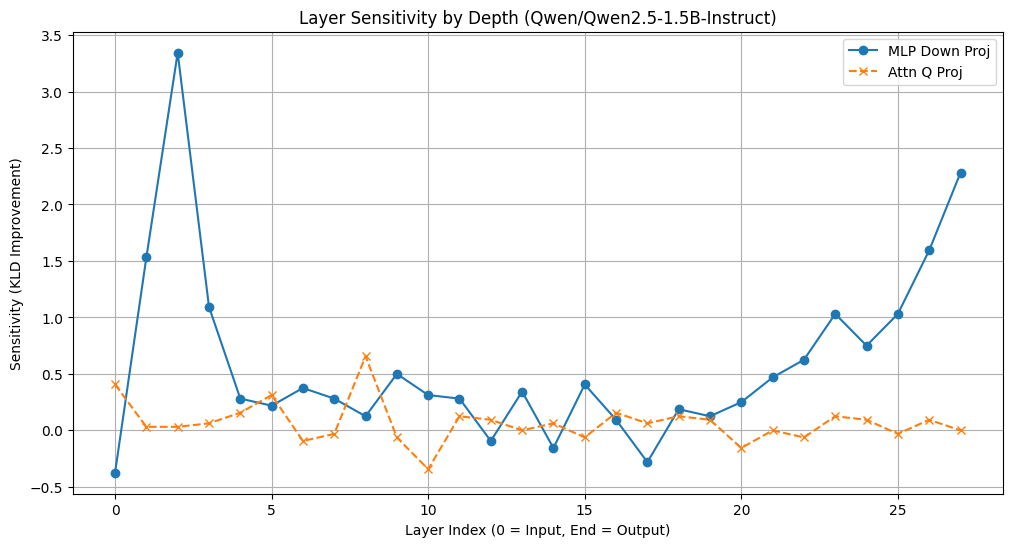

In [15]:
#  --- Generate the layer sensitivity graph --- #
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame for easy analysis
df_sensitivity = pd.DataFrame(list(sensitivity_map.items()), columns=['Layer_Name', 'KLD_Gain'])

# 1. Sort to find the "Top 10 Most Sensitive Layers"
top_10 = df_sensitivity.sort_values(by='KLD_Gain', ascending=False).head(10)
print("=== Top 10 Most Sensitive Layers ===")
print(top_10)

# 2. Extract Layer Patterns (Position vs. Type)
# Create columns for 'Layer_Index' and 'Module_Type'
df_sensitivity['Layer_Index'] = df_sensitivity['Layer_Name'].apply(lambda x: int(x.split('.')[2]) if 'layers' in x else -1)
df_sensitivity['Module_Type'] = df_sensitivity['Layer_Name'].apply(lambda x: x.split('.')[-1])

# 3. Visualization: Sensitivity by Position
plt.figure(figsize=(12, 6))
# Filter only for a specific module type to make the plot clean (e.g., down_proj)
subset = df_sensitivity[df_sensitivity['Module_Type'] == 'down_proj'].sort_values('Layer_Index')
plt.plot(subset['Layer_Index'], subset['KLD_Gain'], marker='o', label='MLP Down Proj')

# Add Q_proj for comparison
subset_q = df_sensitivity[df_sensitivity['Module_Type'] == 'q_proj'].sort_values('Layer_Index')
plt.plot(subset_q['Layer_Index'], subset_q['KLD_Gain'], marker='x', linestyle='--', label='Attn Q Proj')

plt.title(f"Layer Sensitivity by Depth ({CURRENT_MODEL_ID})")
plt.xlabel("Layer Index (0 = Input, End = Output)")
plt.ylabel("Sensitivity (KLD Improvement)")
plt.legend()
plt.grid(True)
plt.savefig("fp4_sensitive_layer.png")
plt.show()

## FP8

In [28]:
# --- Experiment B: FP8 (Native) - Restoration Method ---
print(f"\n--- Starting Experiment B: FP8 {CURRENT_MODEL_ID} ---")

# 1. Define FP8 Wrapper (The "Quantized Layer")
class FP8LinearStorage(nn.Module):
    def __init__(self, original_linear):
        super().__init__()
        self.in_features = original_linear.in_features
        self.out_features = original_linear.out_features
        # Store compressed FP8 weights
        self.weight = nn.Parameter(original_linear.weight.data.to(torch.float8_e4m3fn), requires_grad=False)
        # Keep bias in BF16/FP32 for stability
        if original_linear.bias is not None:
            self.bias = nn.Parameter(original_linear.bias.data, requires_grad=False)
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # On-the-fly dequantize to BF16 for computation
        return F.linear(x, self.weight.to(x.dtype), self.bias)

# 2. Helper: Convert BF16 Model to Global FP8
def convert_to_fp8_global(model, safe_layers={"lm_head"}):
    print("Converting model to Global FP8 (Storage)...")
    modules_to_wrap = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if any(s in name for s in safe_layers):
                continue
            modules_to_wrap.append((name, module))

    for name, module in tqdm(modules_to_wrap, desc="Wrapping Layers"):
        parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
        child_name = name.split('.')[-1]
        parent = model.get_submodule(parent_name) if parent_name else model
        setattr(parent, child_name, FP8LinearStorage(module))
        del module
    torch.cuda.empty_cache()
    return model

# 3. Helper: Profile Restoration Sensitivity (Specialized for FP8 Wrapper)
def profile_fp8_restoration_sensitivity(model_q, base_logits, model_ref, calib_input):
    print("Profiling FP8 Restoration Sensitivity...")
    sensitivity = {}

    # Get Baseline Error (Global FP8 vs Reference)
    with torch.no_grad():
        current_logits = model_q(calib_input).logits
        base_kld = compute_kld(base_logits, current_logits)

    # Identify all wrapper layers
    fp8_layers = [(n, m) for n, m in model_q.named_modules() if isinstance(m, FP8LinearStorage)]

    for name, module in tqdm(fp8_layers, desc="Profiling Layers"):
        # A. Swap to BF16 (Restoration)
        orig_layer = recursive_getattr(model_ref, name)

        # Create temporary BF16 layer to simulate restoration
        temp_linear = nn.Linear(orig_layer.in_features, orig_layer.out_features, bias=(orig_layer.bias is not None)).to(device, dtype=torch.float16)
        temp_linear.weight.data = orig_layer.weight.data
        if orig_layer.bias is not None:
            temp_linear.bias.data = orig_layer.bias.data

        # Swap IN
        recursive_setattr(model_q, name, temp_linear)

        # B. Measure New KLD
        with torch.no_grad():
            cur_logits = model_q(calib_input).logits
            cur_kld = compute_kld(base_logits, cur_logits)

        # C. Score = Reduction in KLD (Higher drop = More Sensitive)
        sensitivity[name] = base_kld - cur_kld

        # D. Swap BACK to FP8 Wrapper
        recursive_setattr(model_q, name, module)
        del temp_linear

    return sensitivity


--- Starting Experiment B: FP8 Qwen/Qwen2.5-1.5B-Instruct ---


In [29]:
# --- Execution of Experiment B ---

# A. Prepare Models
print("Loading BF16 Reference Model...")
model_fp16 = AutoModelForCausalLM.from_pretrained(CURRENT_MODEL_ID, dtype=torch.float16, device_map="auto")

print("Creating FP8 Quantized Model...")
# Clone the structure first to avoid destroying the reference model
model_fp8 = copy.deepcopy(model_fp16)
model_fp8 = convert_to_fp8_global(model_fp8)

# B. Profile Sensitivity
sensitivity_map = profile_fp8_restoration_sensitivity(
    model_q=model_fp8,
    model_ref=model_fp16,
    base_logits = base_logits,
    calib_input=calib_data
)
sorted_layers = sorted(sensitivity_map.items(), key=lambda x: x[1], reverse=True)
all_layer_names = [n for n, s in sorted_layers]

print("Moving Reference Model to CPU to free VRAM...")
model_fp16 = model_fp16.cpu()  # Offload to System RAM
torch.cuda.empty_cache()       # Clear GPU Memory

# C. Incremental Restoration Loop
sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
current_restored_count = 0

for threshold in sorted_thresholds:
    print(f"\nTargeting Threshold: {threshold:.0%} kept in BF16")

    # 1. Determine new layers to fix based on threshold
    target_count = int(len(all_layer_names) * threshold)
    layers_to_fix_now = all_layer_names[current_restored_count : target_count]

    # 2. Perform Surgery (FP8 Wrapper -> BF16 Linear)
    if layers_to_fix_now:
        print(f"Restoring {len(layers_to_fix_now)} additional layers...")
        # Reuse perform_surgery as it overwrites the module
        perform_surgery(model_fp8, layers_to_fix_now, model_fp16)
        current_restored_count = target_count
    else:
        print("No new layers to restore for this step.")

    # 3. Log to WandB & Evaluate
    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=f"{CURRENT_MODEL_ID.split('/')[-1]}-FP8-{threshold}",
        config={"model": CURRENT_MODEL_ID, "threshold": threshold, "method": "KLD-FP8"},
        reinit=True
    )

    acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
        model_fp8, tokenizer, mmlu_dataset, f"KLD-FP8-{threshold}"
    )

    flip = calculate_flip_rate(base_preds, preds)

    # 4. Log Metrics
    wandb.log({
        "Accuracy": acc, "Perplexity": ppl, "Latency": lat, "Static_Memory": static_mem,
        "Peak_Memory": peak_mem, "Flip_Rate": flip, "Threshold": threshold
    })

    results_table.append({
        "Model": CURRENT_MODEL_ID,
        "Method": "KLD-FP8",
        "Threshold": threshold,
        "Acc": acc,
        "Flip": flip,
        "PPL": ppl,
        "Latency": lat,
        "Static Mem": static_mem,
        "Peak Mem": peak_mem
    })

    run.finish()

# Cleanup Resources
del model_fp8
del model_fp16
torch.cuda.empty_cache()
print("Experiment B Complete.")

Loading BF16 Reference Model...
Creating FP8 Quantized Model...
Converting model to Global FP8 (Storage)...


Wrapping Layers:   0%|          | 0/196 [00:00<?, ?it/s]

Profiling FP8 Restoration Sensitivity...


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]

Moving Reference Model to CPU to free VRAM...

Targeting Threshold: 0% kept in BF16
No new layers to restore for this step.


--- Evaluating: KLD-FP8-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.28%, PPL: 6.39, Latency: 1.94s, Static Mem: 1.85GB, Peak Mem: 1.88GB



Targeting Threshold: 5% kept in BF16
Restoring 9 additional layers...
Surgery: Replacing 9 Sensitive Layers with FP16...
Surgery Complete: 9 layers restored.


--- Evaluating: KLD-FP8-0.05 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.98%, PPL: 6.37, Latency: 1.89s, Static Mem: 1.96GB, Peak Mem: 1.99GB



Targeting Threshold: 10% kept in BF16
Restoring 10 additional layers...
Surgery: Replacing 10 Sensitive Layers with FP16...
Surgery Complete: 10 layers restored.


--- Evaluating: KLD-FP8-0.1 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.94%, PPL: 6.35, Latency: 1.89s, Static Mem: 2.07GB, Peak Mem: 2.10GB



Targeting Threshold: 20% kept in BF16
Restoring 20 additional layers...
Surgery: Replacing 20 Sensitive Layers with FP16...
Surgery Complete: 20 layers restored.


--- Evaluating: KLD-FP8-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.98%, PPL: 6.35, Latency: 1.86s, Static Mem: 2.24GB, Peak Mem: 2.27GB



Targeting Threshold: 30% kept in BF16
Restoring 19 additional layers...
Surgery: Replacing 19 Sensitive Layers with FP16...
Surgery Complete: 19 layers restored.


--- Evaluating: KLD-FP8-0.3 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.70%, PPL: 6.33, Latency: 1.86s, Static Mem: 2.36GB, Peak Mem: 2.39GB


Experiment B Complete.


=== Top 10 Most Sensitive Layers ===
                        Layer_Name  KLD_Gain
20    model.layers.2.mlp.down_proj  0.960938
188  model.layers.26.mlp.down_proj  0.625000
13    model.layers.1.mlp.down_proj  0.570312
32    model.layers.4.mlp.gate_proj  0.457031
12      model.layers.1.mlp.up_proj  0.347656
53    model.layers.7.mlp.gate_proj  0.343750
195  model.layers.27.mlp.down_proj  0.285156
34    model.layers.4.mlp.down_proj  0.250000
6     model.layers.0.mlp.down_proj  0.234375
26      model.layers.3.mlp.up_proj  0.226562


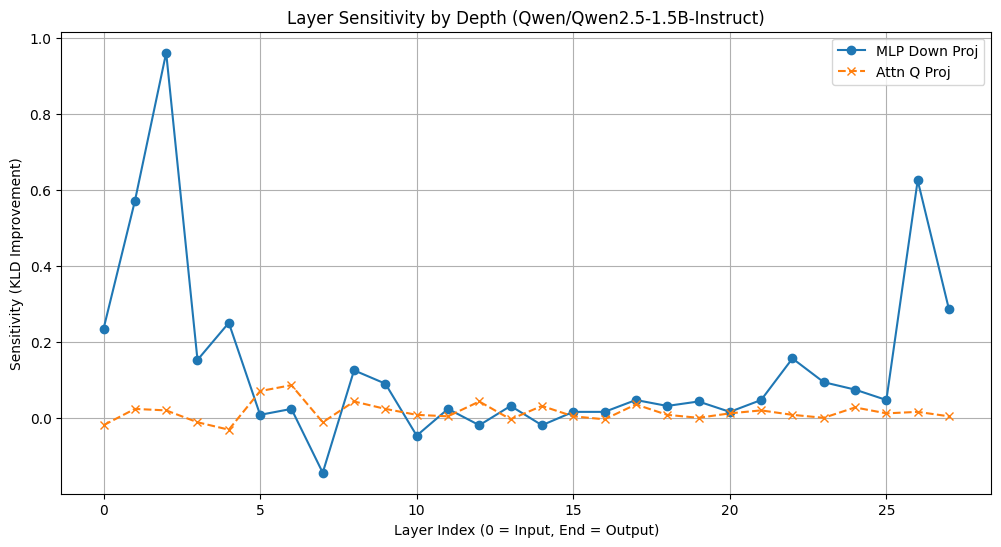

In [31]:
#  --- Generate the layer sensitivity graph --- #
# Convert to DataFrame for easy analysis
df_sensitivity = pd.DataFrame(list(sensitivity_map.items()), columns=['Layer_Name', 'KLD_Gain'])

# 1. Sort to find the "Top 10 Most Sensitive Layers"
fp8_top_10 = df_sensitivity.sort_values(by='KLD_Gain', ascending=False).head(10)
print("=== Top 10 Most Sensitive Layers ===")
print(fp8_top_10)

# 2. Extract Layer Patterns (Position vs. Type)
# Create columns for 'Layer_Index' and 'Module_Type'
df_sensitivity['Layer_Index'] = df_sensitivity['Layer_Name'].apply(lambda x: int(x.split('.')[2]) if 'layers' in x else -1)
df_sensitivity['Module_Type'] = df_sensitivity['Layer_Name'].apply(lambda x: x.split('.')[-1])

# 3. Visualization: Sensitivity by Position
plt.figure(figsize=(12, 6))
# Filter only for a specific module type to make the plot clean (e.g., down_proj)
subset = df_sensitivity[df_sensitivity['Module_Type'] == 'down_proj'].sort_values('Layer_Index')
plt.plot(subset['Layer_Index'], subset['KLD_Gain'], marker='o', label='MLP Down Proj')

# Add Q_proj for comparison
subset_q = df_sensitivity[df_sensitivity['Module_Type'] == 'q_proj'].sort_values('Layer_Index')
plt.plot(subset_q['Layer_Index'], subset_q['KLD_Gain'], marker='x', linestyle='--', label='Attn Q Proj')

plt.title(f"Layer Sensitivity by Depth ({CURRENT_MODEL_ID})")
plt.xlabel("Layer Index (0 = Input, End = Output)")
plt.ylabel("Sensitivity (KLD Improvement)")
plt.legend()
plt.grid(True)
plt.savefig("fp8_sensitive_layer.png")
plt.show()

# Visualization

                         Model         Method  Threshold     Acc    Flip  \
0   Qwen/Qwen2.5-1.5B-Instruct  FP16 Baseline       0.00  0.5734  0.0000   
1   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.00  0.5366  0.2418   
2   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.05  0.5330  0.2522   
3   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.10  0.5322  0.2482   
4   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.20  0.5296  0.2358   
5   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.30  0.5306  0.2212   
6   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.00  0.5728  0.0740   
7   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.05  0.5698  0.0726   
8   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.10  0.5694  0.0718   
9   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.20  0.5698  0.0688   
10  Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.30  0.5670  0.0610   

         PPL   Latency  Static Mem  Peak Mem  
0   6.328403  1.840891    2.883327  2.89

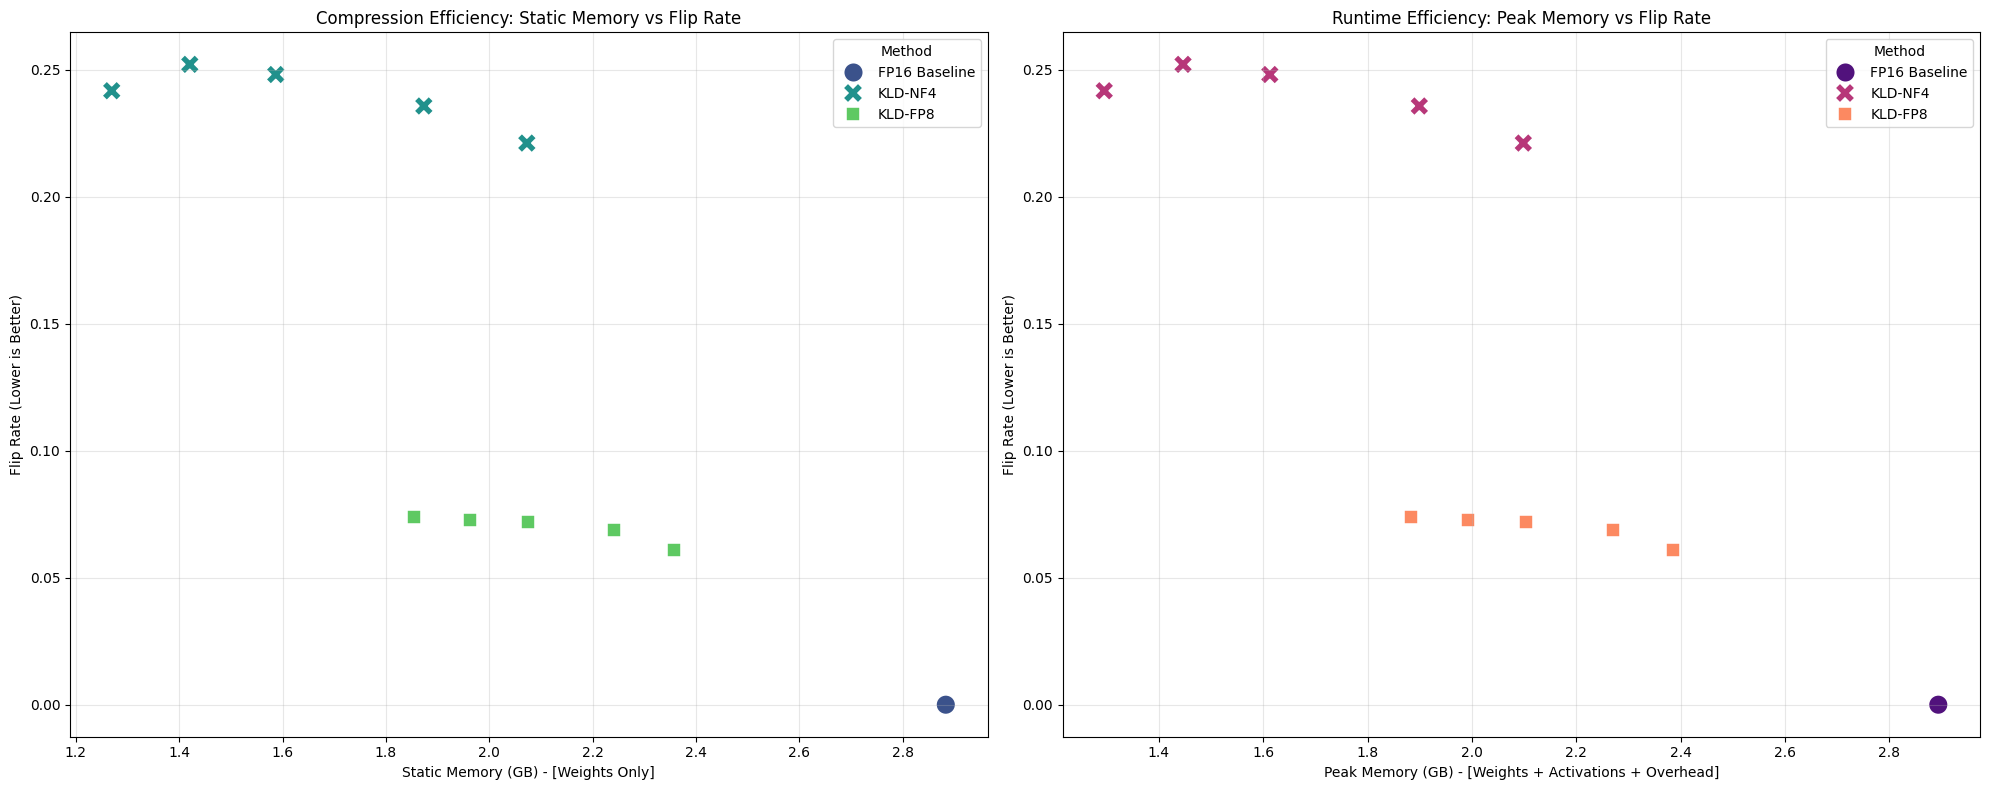

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create DataFrame
df = pd.DataFrame(results_table)

# Display the data
print(df)

# 2. Set up the figure with 2 subplots (Static vs Peak)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot A: Static Memory (Model Size) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Static Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='viridis', ax=axes[0]
)
axes[0].set_title("Compression Efficiency: Static Memory vs Flip Rate")
axes[0].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[0].set_ylabel("Flip Rate (Lower is Better)")
axes[0].grid(True, alpha=0.3)

# Add labels for Plot A
for i in range(df.shape[0]):
    row = df.iloc[i]
    # Check if 'Static_Mem' exists to avoid errors
    if 'Static_Mem' in row:
        axes[0].text(row.Static_Mem + 0.01, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

# --- Plot B: Peak Memory (Runtime Cost) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Peak Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='magma', ax=axes[1]
)
axes[1].set_title("Runtime Efficiency: Peak Memory vs Flip Rate")
axes[1].set_xlabel("Peak Memory (GB) - [Weights + Activations + Overhead]")
axes[1].set_ylabel("Flip Rate (Lower is Better)")
axes[1].grid(True, alpha=0.3)

# Add labels for Plot B
for i in range(df.shape[0]):
    row = df.iloc[i]
    if 'Peak_Mem' in row:
        axes[1].text(row.Peak_Mem + 0.05, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

plt.tight_layout()
plt.savefig("efficiency_frontier_comparison.png")
plt.show()

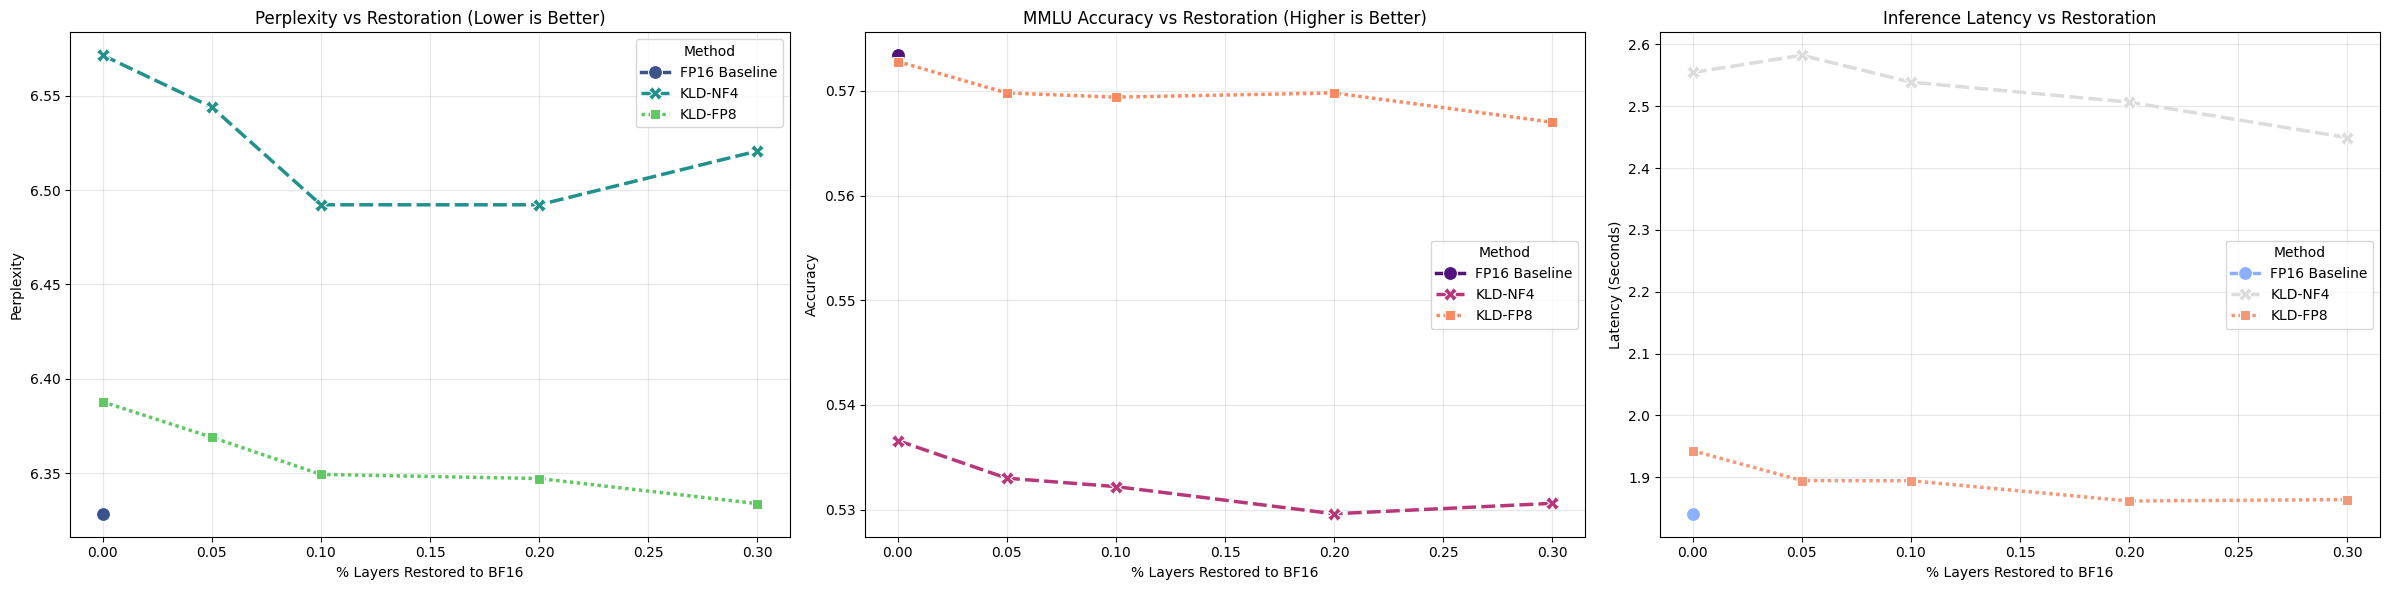

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure DataFrame is ready
df = pd.DataFrame(results_table)

# Set up the figure with 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Plot 1: Perplexity (Lower is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='PPL', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[0], palette='viridis'
)
axes[0].set_title("Perplexity vs Restoration (Lower is Better)")
axes[0].set_xlabel("% Layers Restored to BF16")
axes[0].set_ylabel("Perplexity")
axes[0].grid(True, alpha=0.3)
# axes[0].invert_yaxis()

# --- Plot 2: Accuracy (Higher is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='Acc', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[1], palette='magma'
)
axes[1].set_title("MMLU Accuracy vs Restoration (Higher is Better)")
axes[1].set_xlabel("% Layers Restored to BF16")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)

# --- Plot 3: Latency (Lower is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='Latency', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[2], palette='coolwarm'
)
axes[2].set_title("Inference Latency vs Restoration")
axes[2].set_xlabel("% Layers Restored to BF16")
axes[2].set_ylabel("Latency (Seconds)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("metrics_comparison.png")
plt.show()

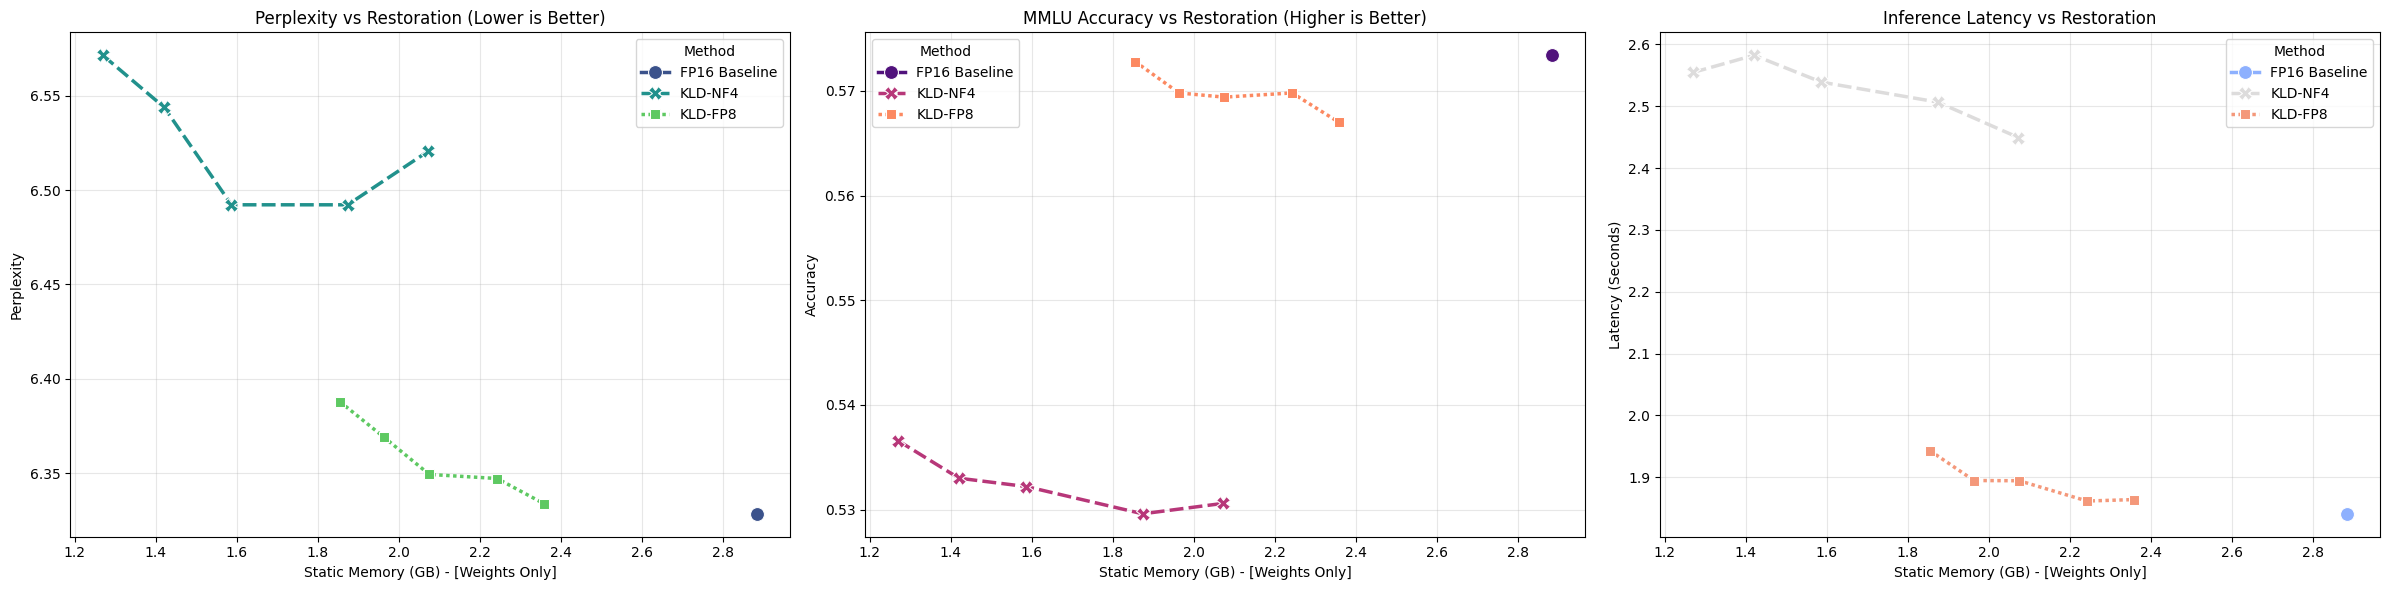

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure DataFrame is ready
df = pd.DataFrame(results_table)

# Set up the figure with 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Plot 1: Perplexity (Lower is Better) ---
sns.lineplot(
    data=df, x='Static Mem', y='PPL', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[0], palette='viridis'
)
axes[0].set_title("Perplexity vs Restoration (Lower is Better)")
axes[0].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[0].set_ylabel("Perplexity")
axes[0].grid(True, alpha=0.3)
# axes[0].invert_yaxis()

# --- Plot 2: Accuracy (Higher is Better) ---
sns.lineplot(
    data=df, x='Static Mem', y='Acc', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[1], palette='magma'
)
axes[1].set_title("MMLU Accuracy vs Restoration (Higher is Better)")
axes[1].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)

# --- Plot 3: Latency (Lower is Better) ---
sns.lineplot(
    data=df, x='Static Mem', y='Latency', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[2], palette='coolwarm'
)
axes[2].set_title("Inference Latency vs Restoration")
axes[2].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[2].set_ylabel("Latency (Seconds)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("metrics_comparison.png")
plt.show()

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# import pandas as pd
# import os
# import shutil # Import shutil for copying files

# # Define the directory to save files in Google Drive
# save_dir = '/content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1'
# os.makedirs(save_dir, exist_ok=True)

# # Save results_table as CSV
# df_results = pd.DataFrame(results_table)
# df_results.to_csv(os.path.join(save_dir, 'exp0_1_results.csv'), index=False)
# print(f"Results table saved to {os.path.join(save_dir, 'exp0_1_results.csv')}") # Corrected print statement

# top_10 = pd.DataFrame(top_10)
# top_10.to_csv(os.path.join(save_dir, 'fp4_top_10_sensitive_layers.csv'), index=False)
# print(f"fp4_top_10_sensitive_layers table saved to {os.path.join(save_dir, 'fp4_top_10_sensitive_layers.csv')}")

# df_fp8_top_10 = pd.DataFrame(fp8_top_10)
# df_fp8_top_10.to_csv(os.path.join(save_dir, 'fp8_top_10_sensitive_layers.csv'), index=False)
# print(f"fp8_top_10_sensitive_layers table saved to {os.path.join(save_dir, 'fp8_top_10_sensitive_layers.csv')}")

# # Copy figures to Google Drive
# figures_to_copy = [
#     'efficiency_frontier_comparison.png',
#     'metrics_comparison.png',
#     'fp8_sensitive_layer.png',
#     'fp4_sensitive_layer.png'
# ]

# for fig_name in figures_to_copy:
#     fig_path = os.path.join('/content', fig_name)
#     if os.path.exists(fig_path):
#         # Use shutil.copy2 to copy the file, then os.remove to delete the original
#         shutil.copy2(fig_path, os.path.join(save_dir, fig_name))
#         # os.remove(fig_path) # Remove original after copying
#         print(f"Copied {fig_name} to {os.path.join(save_dir, fig_name)} and removed original.")
#     else:
#         print(f"Figure {fig_name} not found in current directory.")

Results table saved to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/exp0_1_results.csv
fp4_top_10_sensitive_layers table saved to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/fp4_top_10_sensitive_layers.csv
fp8_top_10_sensitive_layers table saved to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/fp8_top_10_sensitive_layers.csv
Copied efficiency_frontier_comparison.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/efficiency_frontier_comparison.png and removed original.
Copied metrics_comparison.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/metrics_comparison.png and removed original.
Copied fp8_sensitive_layer.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/fp8_sensitive_layer.png and removed original.
Copied fp4_sensitive_layer.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/fp4_sensitive_layer.png and removed or